In [1]:
import json
import os
import numpy as np
import itertools

from transformers import PreTrainedTokenizerFast, AutoTokenizer, AutoConfig
from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from notebook_utils import *

In [18]:
# disable FutureWarning from seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the results for XNLI (cross-lingual transfer)

In [3]:
result_dir = "../../../models"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')

tokenizer_types = ('bpe-tokenization', 'merged-tokenization', 'multilingual-tokenization', 'nooverlap-tokenization')
vocab_sizes = (120000, 120000, 120000, 20000)

In [4]:
task = 'XNLI'
metric = 'accuracy'

xnli_results = []

for post_training, seed in [('PROBE', 8888), ('FT', 1234), ('PROBE_XNLI_HEAD', 1234)]:
    for lang_src in languages:
        for lang_tgt in languages:
            for tok_type, vocab_size in zip(tokenizer_types, vocab_sizes):
                probe = "_probe" if post_training in ("PROBE", "PROBE_XNLI_HEAD") else ""
                result_file = f"{result_dir}/{task}_{post_training}/{tok_type}/alpha-0.25_alpha-train-0.25_N-{vocab_size}{probe}_{seed}/{lang_src}/{metric}_evaluation/{lang_tgt}/{metric}_all.txt"
                
                if not os.path.exists(result_file):
                    print("not found! skipping", result_file)
                    continue
                with open(result_file, 'r') as in_file:
                    res = json.load(in_file)[f'eval_{metric}']

                xnli_results.append(
                    {
                        'lang_src': lang_src,
                        'lang_tgt': lang_tgt,
                        'tokenizer_type': tok_type,
                        'post_training': post_training,
                        'vocab_size': vocab_size,
                        'accuracy': res
                    }
                )

In [10]:
df_all = pd.DataFrame(xnli_results)
df_all['lang_src'] = pd.Categorical(df_all['lang_src'], categories=df_all['lang_src'].unique())
df_all['lang_tgt'] = pd.Categorical(df_all['lang_tgt'], categories=df_all['lang_tgt'].unique())

In [22]:
def plot_boxplot(df, post_training):
    df = df[df['post_training'] == post_training]
    ax = sns.boxplot(x='tokenizer_type', y='accuracy', data=df, showmeans=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.title(f"mean XNLI {post_training} {metric} for all languages")

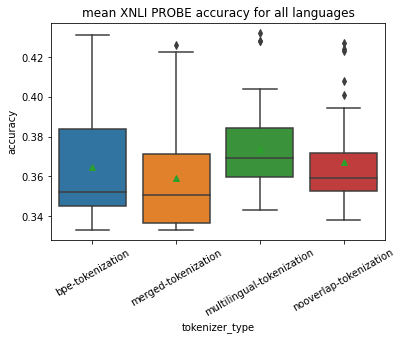

In [23]:
plot_boxplot(df_all, 'PROBE')

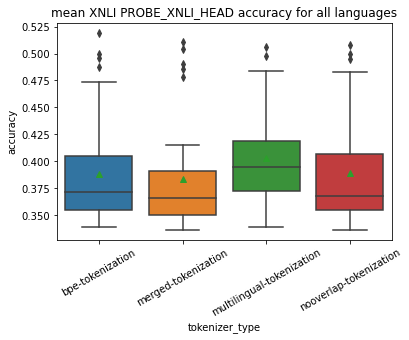

In [24]:
plot_boxplot(df_all, 'PROBE_XNLI_HEAD')

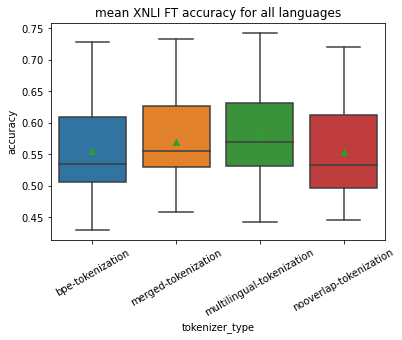

In [25]:
plot_boxplot(df_all, 'FT')

In [34]:
def plot_barplots(df, post_training):
    df = df[df['post_training'] == post_training]
    # plot barplot FacetGrid for lang_src and lang_tgt with tokenizer_type as hue and accuracy as value
    g = sns.FacetGrid(df, col="lang_src", row="lang_tgt", hue="tokenizer_type", margin_titles=True)
    g.map(sns.barplot, "tokenizer_type", "accuracy", order=tokenizer_types)
    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    # plt.title(f"XNLI {post_training} {metric} for the crosslingual transfers")
    # show legend
    g.add_legend()
    plt.show()

In [70]:
def plot_heatmaps(df, baseline, baseline_title, compared=[], compared_titles=[]):
    # plot heatmap for lang_src and lang_tgt with accuracy as value for tokenizer_type == 'multilingual-tokenization'
    # make 3 plots horizontally
    fig, axs = plt.subplots(1, 1+len(compared), squeeze=False, figsize=(30, 5))
    df_baseline = df[baseline]
    df_baseline = df_baseline.pivot("lang_src", "lang_tgt", "accuracy")
    sns.heatmap(df_baseline, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[0][0])
    axs[0][0].set_title(f"XNLI accuracy with {baseline_title}")
    # plt.show()
    # plot heatmaps for the rest of the tokenizer_types as a delta to 'multilingual-tokenization'
    for i, comp, compared_title in zip(range(1, len(compared)+1), compared, compared_titles):
        ax = axs[0][i]
        df_delta = df[comp]
        df_delta = df_delta.pivot("lang_src", "lang_tgt", "accuracy")
        df_delta = df_delta - df_baseline
        # choose a diverging colormap
        # set the scale to be between -1 and 1
        sns.heatmap(df_delta, annot=True, fmt=".2f", cmap="RdBu", vmin=-0.1, vmax=0.1, ax=ax)
        ax.set_title(f"{compared_title} - {baseline_title}")
    plt.show()

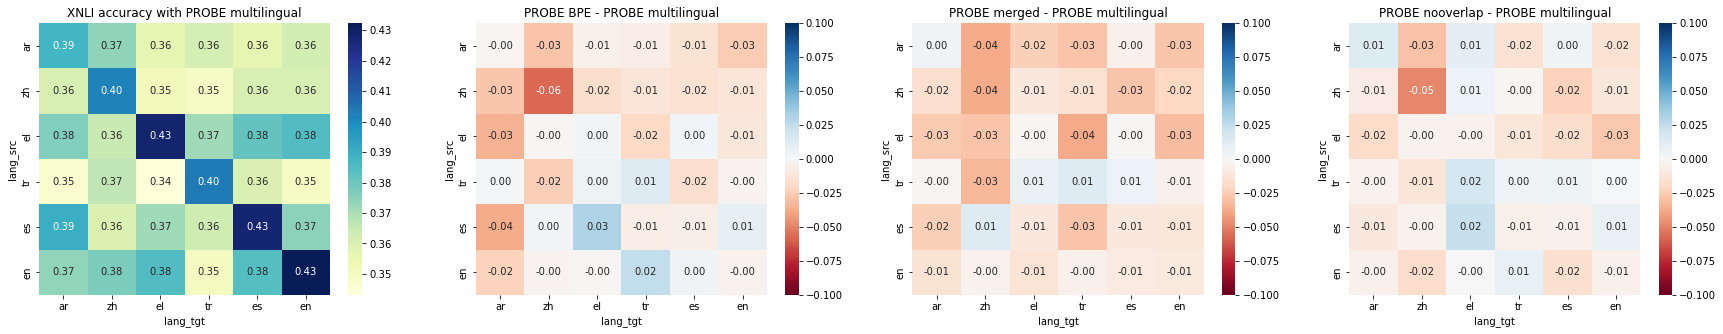

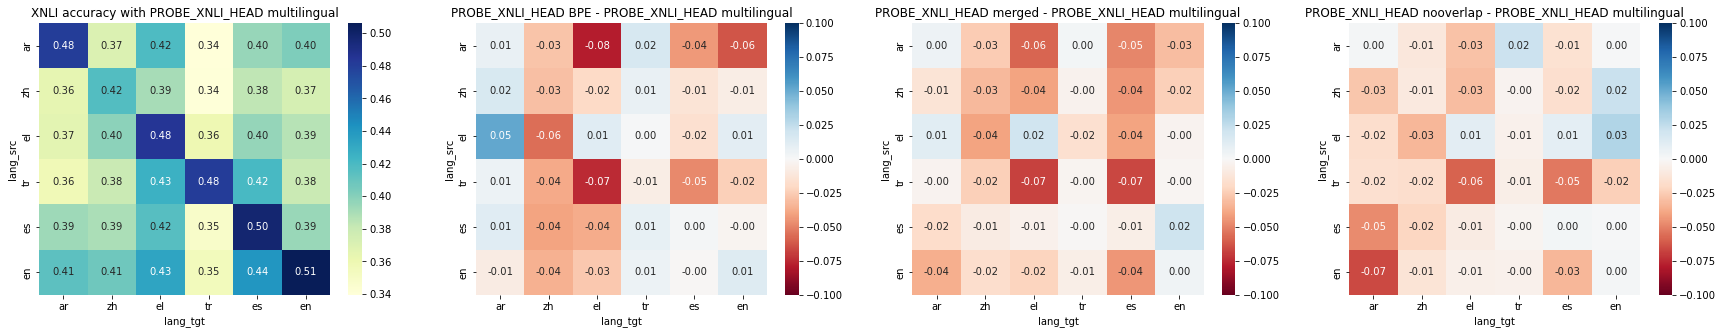

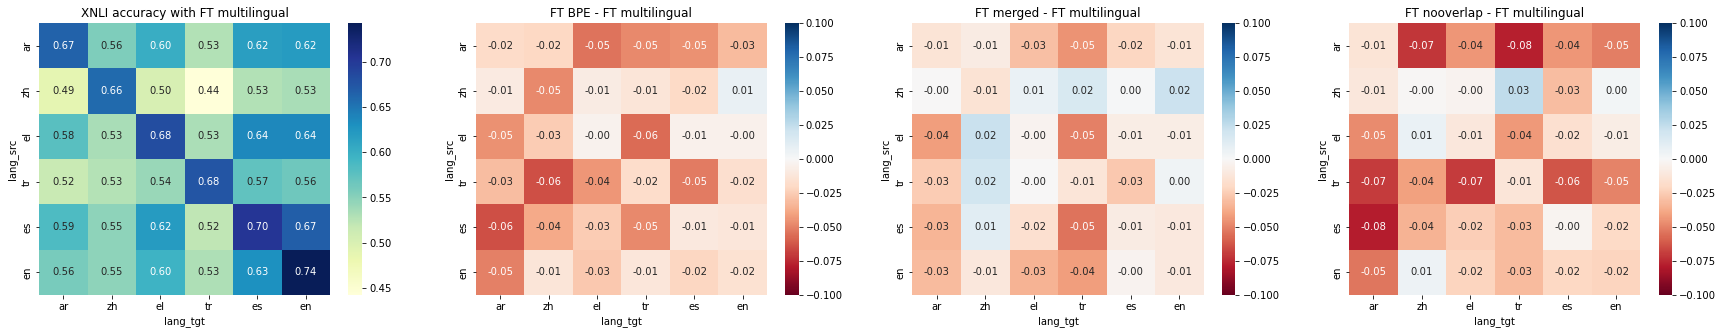

In [71]:
for post_training in ('PROBE', 'PROBE_XNLI_HEAD', 'FT'):
    df = df_all[df_all['post_training'] == post_training]
    plot_heatmaps(df, df['tokenizer_type'] == 'multilingual-tokenization', f'{post_training} multilingual', 
        compared=[df['tokenizer_type'] == 'bpe-tokenization', df['tokenizer_type'] == 'merged-tokenization', df['tokenizer_type'] == 'nooverlap-tokenization'], 
        compared_titles=[f'{post_training} BPE', f'{post_training} merged', f'{post_training} nooverlap']
        )

Text(0.5, 1.0, 'mean XNLI accuracy with multilingual-tokenization')

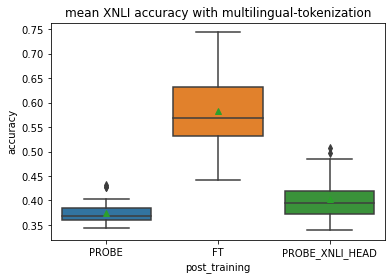

In [73]:
df = df_all[df_all['tokenizer_type'] == 'multilingual-tokenization']
sns.boxplot(x='post_training', y='accuracy', data=df, showmeans=True)
plt.title(f"mean XNLI {metric} with multilingual-tokenization")